# Distracted Driving Prediction
## Deep Learning with python, keras & tensorflow
### Sean O'Malley


The goal of this analysis is to identify the various types of distracted driving scenarios simply using images. We will accomplish this by using deep learning in python with the keras and a tensorflow backend. 

As a contextual reference, deep learning is a subset of machine learning that allows algorithms to train itself in order to perform tasks like image and speech recognition. Deep learning accomplishes this by revealing immense amounts of data to multi-layered neural networks.

__This document will walk you through the entire process of:__ 
* Ingest a list of images
* Transform them into something that can be understood by a computer
* Split into test and training groups
* Prepare data to fit into a deep learning model
* Model builds

__The Following Model Types Will Be Built:__
1. Sequential API deep learning model
2. Sequential API deep learning model  _using BatchNormalization_
3. Functional API deep learning model
4. Functional API deep learning model  _with inception module architecture_
5. Functional API deep learning model  _inception module architecture using BatchNormalization_
 
I will provide commentary, summary statistics and visualization along the way, to help determine the most successful model to move forward with in identifying distracted driving via images. 

We will conclude with a summary of the strengths, weaknesses and opportunities for improvement in the models to help fully understand the data, the models and the ultimate application of the analysis.


__Package Import__

In [210]:
# Basic Packages
import time
import numpy as np
import pandas as pd
import os, sys

# Deep Learning Packages
from keras.models import Sequential, Model, model_from_json
from keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical, np_utils

from keras import backend as K
from keras.optimizers import Adam, RMSprop
import h5py

# Image Import & View Packages
import glob
import matplotlib.pyplot as plt
from PIL import Image


__Exploratory Data Analysis__

Ingest and view summaries of csv's to help us gain an understanding of the data we have. Looking at the data below, you'll see that we have 10 classes of images, living in separate photos. The photos are already categorized in their predefined classes by folders.

In [211]:
driver_imgs_list = pd.read_csv('driver_imgs_list.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [212]:
driver_imgs_list.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


Keep in mind that what we see below will need to be the format we follow for our analysis submission.

In [213]:
sample_submission.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,img_100.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,img_1000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,img_100000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


__Image Characteristics__

We see that the images are jpegs, 640x480 pixels and in full RGB color.

JPEG (640, 480) RGB


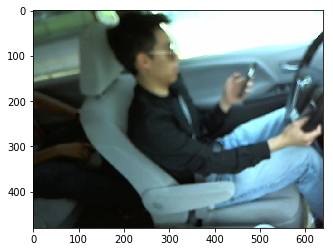

In [214]:
%matplotlib inline

imagetest = Image.open('imgs/test/img_2200.jpg')

print(imagetest.format, imagetest.size, imagetest.mode)

plt.imshow(imagetest)

__Manipulate and Transform Image Data__

The below outer for loop ingests each image from their respective folders while maintaining the classification of the image.

The nested for loop takes each image, converts it to black and white, reduces the image by a magnitued of 10, puts the image pixel values into a numpy array, appending values to the respective X (train) and y (test) lists.

In [215]:
X = []
y = []
for j in range(10):
    print('Load folder c{}'.format(j))
    path = os.path.join('imgs', 'train', 'c' + str(j), '*.jpg')
    img_list = glob.glob(path)
    for file in img_list:
        img = Image.open(file).convert('L')
        height, width = img.size
       # thumbnail is a in-place operation
        img = img.resize(( int(height/10), int(width/10) ), Image.ANTIALIAS) #, Image.ANTIALIAS
        pix = np.array(img.getdata()).reshape(img.size[0],img.size[1],1)
        X.append(pix)
        y.append(j)
        
    print("Number of train images: %s" % len(X))

Load folder c0
Number of train images: 2489
Load folder c1
Number of train images: 4756
Load folder c2
Number of train images: 7073
Load folder c3
Number of train images: 9419
Load folder c4
Number of train images: 11745
Load folder c5
Number of train images: 14057
Load folder c6
Number of train images: 16382
Load folder c7
Number of train images: 18384
Load folder c8
Number of train images: 20295
Load folder c9
Number of train images: 22424


__Encode X and y__

Because we are attempting to classify the images, we need to change y to categorical data for keras to understand what it is trying to classify. We also need to alter X to be a numpy array because the loop outputs a list.

In [216]:
Y = to_categorical(y)
print(Y.shape)

(22424, 10)


In [217]:
X = np.array(X) 
print(X.shape)

(22424, 64, 48, 1)


__Test / Train Shuffle and Split__

We then take the X and y lists and turn them into float value numpy arrays. After that, we shuffle the order of the data image by index and then split into test and train groups.

Prep Shuffle on index

In [218]:
ind = np.array(list(range(22424)))
seed = 500
np.random.seed(seed)
np.random.shuffle(ind)
print(ind[:10])

[ 9994  4965  5208  2681 15911  5972   547 12219 18670 16198]


Apply shuffle to test and train

In [219]:
Xs = X[ind]
Ys = Y[ind]

__Determine validity of split__

Comparing X with Xs we can see that we have properly shuffled our test / train split.

In [220]:
print("shape of Ys:" + str(Ys.shape))
print("shape of Xs:" + str(Xs.shape))

shape of Ys:(22424, 10)
shape of Xs:(22424, 64, 48, 1)


Y looks properly shuffled

In [221]:
print(Y[0], Ys[0])

[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.] [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


X also looks like things have been shuffled correctly

In [222]:
X[0].sum() - Xs[0].sum()

35584

__Normalization Process__

In [223]:
print(Xs.dtype)
print(Xs.max()) 

int64
255


In [224]:
Xs = (Xs-(Xs.max()/2))/Xs.max()

In [225]:
print(Xs.dtype)
print(Xs.mean())
print(Xs.max())
print(Xs.min())

float64
-0.142253596592
0.5
-0.5


Alter datatype to float to create more disk space

In [226]:
print("original disk space with " + str(Xs.dtype) + " is " + str(Xs.nbytes/10**9)) 
Xs = Xs.astype('float32')
print("new disk space: "  + str(Xs.dtype) + " is " + str(Xs.nbytes/10**9)) 

original disk space with float64 is 0.551092224
new disk space: float32 is 0.275546112


__Save to HDF5 file type__

Due to size and hierarchical data structure I am saving off a copy of the afore-created data results. I will also re-ingest the data in a way that automatically creates the test and train groups for our model to learn on. 

_Save Data_

In [227]:
with h5py.File('traindata.hdf5','w') as f:
    f.create_dataset('X', data=Xs)
    f.create_dataset('Y', data=Ys)

_Read Data Back In_

In [228]:
with h5py.File('traindata.hdf5','r') as f:
    X_train = f['X'][()] 
    Y_train = f['Y'][()]

__Visualize Shape before modeling__

We want to see the structure of the data we are using to teach our model.

In [229]:
print("X Train")
print(X_train.shape)

print("Y Train:")
print(Y_train.shape)

X Train
(22424, 64, 48, 1)
Y Train:
(22424, 10)


__Prep Before Model Builds__

We first want to prep the inputs to the model. Pulling out the number of classes and ensuring that y is categorical 

In [230]:
num_pixels = X_train.shape[1] * X_train.shape[2]
print(num_pixels)

num_classes = Y_train.shape[1]
print(num_classes)

3072
10


__Basic CNN Sequential Model:__ _Build_

The <a href="https://keras.io/models/sequential/">Sequential API</a> allows you to create models layer by layer after initiating the _Sequential()_ function in a model. The operations are limited in that Sequential does not allow you to create models that share layers or have multiple inputs or outputs. However this simple model can prove incredibly effective, permitting you to summarize, fit, evaluate and make predictions.

Now, lets build the most basic sequential model and see how it performs

In [231]:
# Create Model as Function
def sequential_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = (64, 48, 1)))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(units = num_pixels, activation = 'relu'))
    model.add(Dense(units = num_classes, activation = 'softmax'))

    model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=['accuracy'])
    return model

In [ ]:
# Build Model
model = sequential_cnn_model()

# View Model Summary
print(model.summary())

# Fit Model
history = model.fit(X_train, Y_train, validation_split = 0.25, epochs=20, batch_size=200, verbose=2)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 46, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 23, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 22816)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 3072)              70093824  
_________________________________________________________________
dense_6 (Dense)              (None, 10)                30730     
Total params: 70,124,874
Trainable params: 70,124,874
Non-trainable params: 0
_________________________________________________________________
None
Train on 16818 samples, validate on 5606 samples
Epoch 1/20


__Basic CNN Sequential Model:__  _Evaluate_

The model above is incredibly simplistic, but performed fairly well with a baseline error rate of 3.62%. The model follows an irregular learning pattern.

Baseline Error: 3.62%


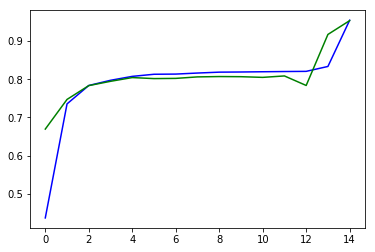

In [82]:
# Evaluate Model Accuracy
scores = model.evaluate(X_train, Y_train, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

# Visualize Model
plt.plot(history.history['acc'],'b') #train acc
plt.plot(history.history['val_acc'],'g') #val acc

__Basic Sequential Model:__  _Save_

We want so save this specific model off as a json, and weights to hdf5 for reusability purposes

In [83]:
# serialize model to JSON
model_json = model.to_json()
with open("sequential_cnn_model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("sequential_cnn_model.h5")
print("Saved model to disk")

Saved model to disk


__Ingest The Final Test Data__

This is the final test data our model will attempt to classify. We do now have a access to the actual classification values of this test data, so to test / train our model we will divide the previously classified data into test and train data then run the model we built against this unknown distracted driver data.

In [ ]:
X_Final_Test = []
path = os.path.join('imgs', 'test','*.jpg')
img_list = glob.glob(path)
print(len(img_list))

for file in img_list:
    img = Image.open(file).convert('L')
    height, width = img.size
    # thumbnail is a in-place operation
    img = img.resize(( int(height/10), int(width/10) ), Image.ANTIALIAS) #, Image.ANTIALIAS
    pix = np.array(img.getdata()).reshape(img.size[0],img.size[1],1)
    X_Final_Test.append(pix)
        
print("Number of test images: %s" % len(X_test))

# Turn to float and normalize for color
X_Final_Test = np.array(X_Final_Test, dtype = 'float32' 
X_Final_Test = X_Final_Test / 255             
print(X_Final_Test.shape)

__Save A Copy Of Test Data__

In [ ]:
with h5py.File('testdata.hdf5','w') as f:
    f.create_dataset('X', data=X_Final_Test)

__Basic CNN Sequential Model:__ _Predict Final Test Data_

Using the basic sequential model we will create a prediction on the untouched final test group.

In [182]:
sequential_cnn_model_pred = model.predict(X_Final_Test)

In [183]:
pred_names = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']

pred_path = 'imgs/test'
pred_filenames = os.listdir(pred_path)

In [184]:
print("Length of filenames: " + str(len(pred_filenames)))
print("Length of simple_sequential_model_pred: " + str(sequential_cnn_model_pred.shape[0]))

Length of filenames: 79726
Length of simple_sequential_model_pred: 79726


__Below is highlighting that something is screwy with my classification__

In [185]:
sequential_cnn_model_pred_df = pd.DataFrame(sequential_cnn_model_pred, 
                                               index = pred_filenames, 
                                               columns = pred_names)

sequential_cnn_model_pred_df = sequential_cnn_model_pred_df.reset_index()
sequential_cnn_model_pred_df.rename(columns={'index': 'img'}, inplace=True)
sequential_cnn_model_pred_df.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,img_10.jpg,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,img_100.jpg,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,img_1000.jpg,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,img_100000.jpg,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [186]:
sequential_cnn_model_pred_df.to_csv('sequential_cnn_model_pred.csv', index=False, sep = ',')

__Basic CNN Sequential Model:__ _Submission Results_

We submitted our most basic model with expected results

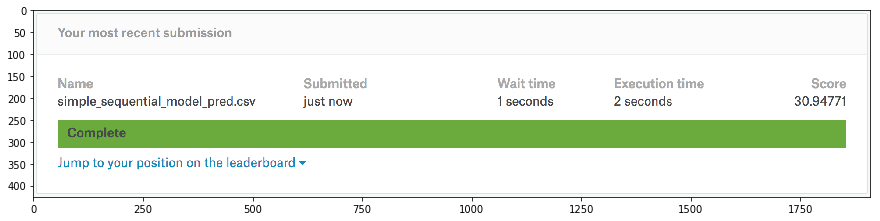

In [187]:
%matplotlib inline

RESULTS_simple_sequential_model_pred = Image.open('RESULTS_simple_sequential_model_pred.png')

plt.figure(figsize = (15,5))
plt.imshow(RESULTS_simple_sequential_model_pred)

<font color="red">__We can see that something has gone awry in that we are classifying everything as 'looking at the radio' which deviates from what the model was wanting to give us in the test / train split__</font>

In [204]:
simple_sequential_model_pred_df[simple_sequential_model_pred_df.columns[1:]].sum()

c0        0.302500
c1        0.291706
c2        0.283884
c3        0.291243
c4        0.302067
c5    79723.312500
c6        0.290006
c7        0.306165
c8        0.304385
c9        0.311561
dtype: float32